# Exploring Online Order Sales Data

For this challenge, I explore 2 medium sized datasets from an online retailer. The datasets contain transactions and records of the visitors to the site. 

**Goal::** Glean insights and opportunities from this data to drive decision making to generate organic growth.

Online retail is a crowded space. New players are up against industry heavyweights like Amazon, Walmart and AliBaba. To stand out in the crowd, retailers must understand their users' motivation to use their services and make the shopping experience as seamless and convenient as possible. To achieve these goals we muat identify opportunities for improvement and optimization.

In this exploratory journey through the data, we will search for such opportunities for growth.

## Importing the Libraries

In [53]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from IPython.display import display, Markdown

np.printoptions(precision=4, suppress=True)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

## Importing the Data

In [2]:
os.chdir('..')

In [3]:
DATA_PATH = os.getcwd() + '//data//'
trx_file = 'transactions_202001.csv'
visitor_file = 'visitors_202001.csv'

In [4]:
trx = pd.read_csv(DATA_PATH + trx_file, low_memory=False)
print(trx.shape)
trx.head()

(120662, 7)


,user_id,transaction_id,time,country,items,total,returned_items
0,cadeed9426d287cb9cb651cd7ed4f103,2fa41e338cf91fffba68c6f9fb80add6,1541185315,A,1,18.5600,0
1,bb3936cb7bb0f605d187a52ff5e03438,795caad659fc9038034aaf5ecf873e61,1541185411,A,4,34.0200,0
2,ae2178e497fc7a38917d950e52ff22ec,29fe89653bb7268b3a7ade23387ba326,1541185455,A,15,346.3900,0
3,3421071b1e44d7160cac7dc6accb4f50,a6e04c84c1dd826a6036e26ea513951d,1541185510,C,1,18.5600,0
4,82798f7788ad20ce34118c925055c06b,7c849f99090de7ec2322d6d31472a607,1541185706,A,1,58.7600,0


In [5]:
visitors = pd.read_csv(DATA_PATH + visitor_file, low_memory=False)
print(visitors.shape)
visitors.head()

(1981904, 9)


,user_id,client,ip_country,gender,year_born,channel,time,minutes,session_id
0,de4c93c3293c76f3aa95c4c57be7e09f,androidapp,A,F,1948,paid,1525762800,4,cfd3f6f2eda4c859d19f5cef56f26351
1,0e399e7047198e3a9fc8c2baed521d60,web,B,M,1985,organic,1525762800,35,54b4133384ab0bfa97675240fa939007
2,2fbb988aa25afb749bfe86bb314a79cb,iosapp,A,F,1999,organic,1525762800,4,b609d8ffaaf5e80075836dcf32580b04
3,763019e3db7510769a85cec170abf53d,androidapp,C,F,1985,organic,1525762800,5,49759218c2c231d4d41592facd2811d0
4,b6835da7d9d3595b6e12c100fca1d51c,iosapp,A,F,1960,organic,1525762800,5,433ae77787d29e5d57778d0c65143ad2


## Exploratory Data Analysis

### Summary judgements

 *  We have 2 datasets - **visitors** and **transactions**. **Visitors** is the larger of the 2 which is a characteristic of online shopping since not every visit translates to a purchase. 
 *  1.98 Million rows in `visitors`, 120662 rows in `trx`, which roughly translates to a purchase every 16 visits. Ideally every online retailer would like to minimize that ratio (while increasing both visitors and transactions). As we explore this data further we'll see if we can find solutions and opportunities to this question of growth.
 *  `country` and `ip_country` in both datasets seem to be anonymized. But there are multiple countries indicating a multi-national operation. This could form an important segmentation feature along with `channel` and `client`.
 *  Categorical Variables - 
     *  `country` (`trx`)
     *  `ip_country` (`visitors`)
     *  `client` (`visitors`)
     *  `gender` (`visitors`)
     *  `channel` (`visitors`)

### Assumptions

 *  `time` in `trx` is the **checkout** UNIX timestamp.
 *  `time` in `visitors` is the **session start** UNIX timestamp.
 *  Single users can have multiple session IDs. i.e. primary key in `visitors` is `session_id` + `user_id` or `session_id` on it's own.
 *  Similarly primary key in `trx` is `user_id` + `transaction_id` or `transaction_id` on it's own.
 *  Even though `trx` and `visitors` both have `user_id` joining these datasets is harder than it looks. Since `trx` lacks `session_id` to connect a visit to a purchase we will need to creatively use time to come up with a way to join the 2 tables. Something like : `time (visitors)` + `minutes (visitors)` == `time (trx)`
 *  `channel == paid` indicates how those visitors were acquired from a session perspective. I'm assuming `paid` implies the visitor clicked on an ad to reach the online retailer's website, whereas `organic` implies the user searched specifically for the said item in the online retailer's inventory.
 

<h4> Opportunity 1 - Record session_id for Transactions </h4>

For discovery of more granular attributes, like: **How long did user x look at item y before deciding to buy it?** we should recording `session_id` in the `transaction` table to tie the transactional attributes to the session attributes. We should also keep a log of the items looked at (in `visitors`) and purchased (in `transactions`). I understand that this will cause the data sizes to grow rapidly as each item looked at or purchased will be a row in the new tables, but the value provided by knowing user browsing and buying behavior will far outstrip the expense of database storage.


### Sanity checks

In [6]:
trx.dtypes

user_id            object
transaction_id     object
time                int64
country            object
items               int64
total             float64
returned_items      int64
dtype: object

In [7]:
len(trx['user_id'].unique())
## 27k users responsible for 120k trx

27072

In [8]:
len(trx['transaction_id'].unique())
## since this is equal to num of trx => transaction_id is primary key

120662

In [9]:
visitors.dtypes

user_id       object
client        object
ip_country    object
gender        object
year_born      int64
channel       object
time           int64
minutes        int64
session_id    object
dtype: object

In [10]:
len(visitors['user_id'].unique())
## 118k unique visitors, of which 27k have made trx

118577

In [11]:
print(len(visitors['session_id'].unique()))
print(visitors.shape[0])
## this is not equal to num of visitors, we have 18 fewer sessions than visitors. Outliers?

1981896
1981904


### Missing Data

user_id              0
transaction_id       0
time                 0
country           1351
items                0
total                0
returned_items       0
dtype: int64

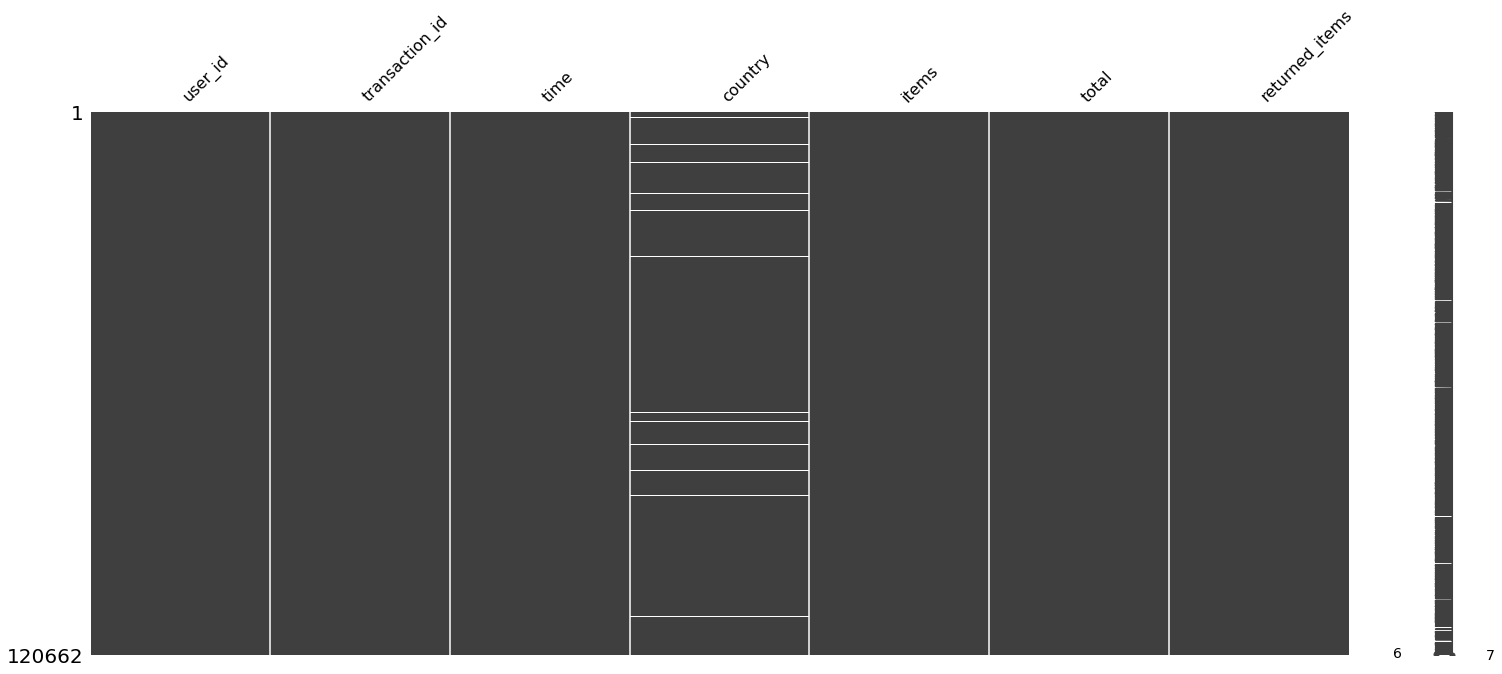

In [12]:
msno.matrix(trx)
trx.isnull().sum()

`country` has missing values, we can solve this by - 
1.  imputing the mode (i.e Most common country)
2.  identifying the users and using a location previously recorded for them
3.  using `ip_country` from `visitors` for the corresponding user.

Let's try approach 1

In [13]:
##0a. Check distribution by country
print(trx['country'].value_counts())
##0b. How many missing values?
print(trx[trx.isnull().any(axis=1)].shape[0])
##1. Since, the number of rows missing country is small and country A is the mode by a large margin, 
## we can safely use mode for missing value imputation
trx['country'].fillna(trx['country'].mode()[0], inplace=True)
##2. Check for missing
print(trx[trx.isnull().any(axis=1)].shape[0])

A    80131
B    24339
C    14841
Name: country, dtype: int64
1351
0


In [14]:
# ##1. tie each user to a country:: Group by user, get all countries for that user, get the mode by agg
# user_country = trx.groupby('user_id')['country'].agg(pd.Series.mode)
# ##2. find users with missing country
# missing_country = trx[trx.isnull().any(axis=1)]
# ##3. Join the two
# joined_df =  pd.merge(missing_country, user_country, on='user_id')
# ##4. country_y now has the imputed values, drop country_x and rename country_y to country
# joined_df.drop(['country_x'], inplace=True, axis=1)
# joined_df.rename({'country_y':'country'}, axis=1, inplace=True)
# ##5. Join back to trx
# trx = joined_df[['user_id', 'transaction_id', 'country']]

user_id       0
client        0
ip_country    0
gender        0
year_born     0
channel       0
time          0
minutes       0
session_id    0
dtype: int64


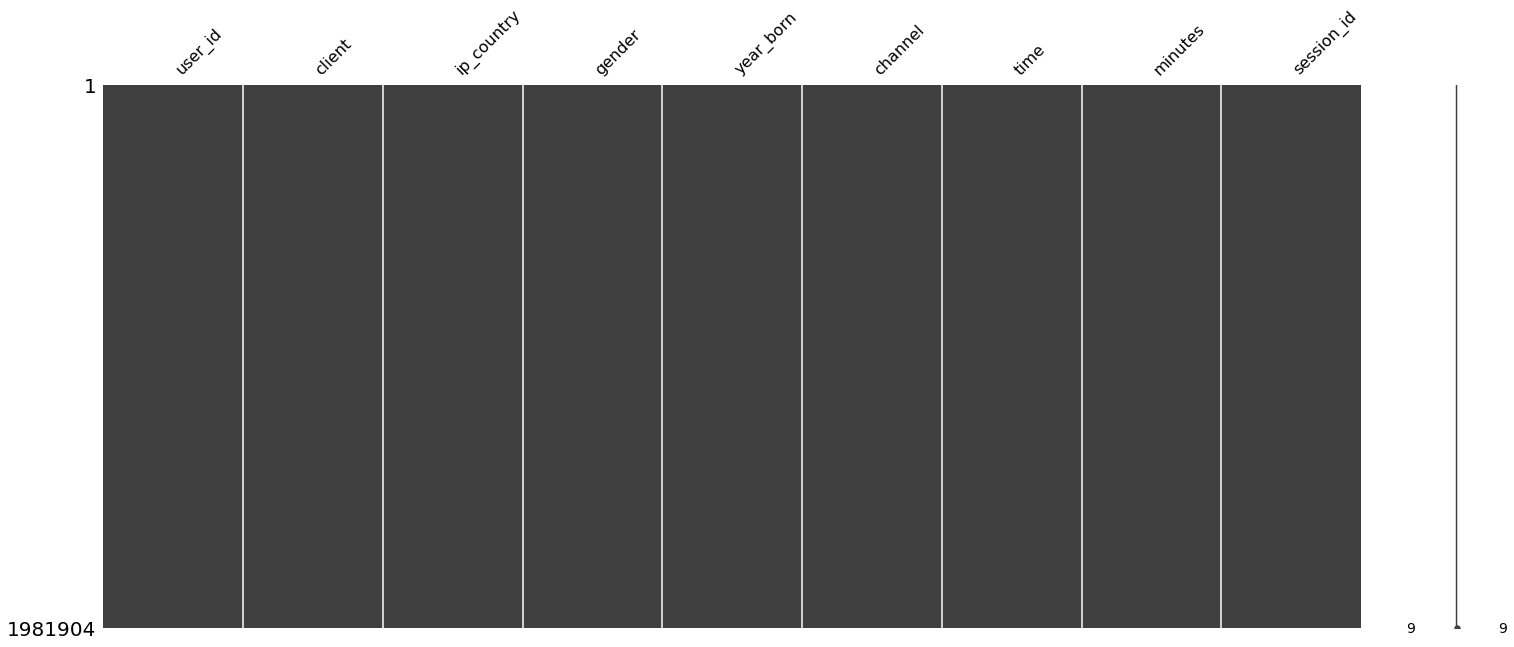

In [15]:
msno.matrix(visitors)
print(visitors.isnull().sum())

### Statistics and Counts

In [16]:
trx.describe()

,time,items,total,returned_items
count,120662.0000,120662.0000,120662.0000,120662.0000
mean,1533957195.1148,2.0053,51.2164,0.1039
std,6231111.4838,2.2076,93.8662,0.4091
min,1522566459.0000,1.0000,0.0000,0.0000
25%,1528586442.7500,1.0000,9.2800,0.0000
50%,1534601885.0000,1.0000,21.6500,0.0000
75%,1539402512.5000,2.0000,61.8600,0.0000
max,1543651177.0000,50.0000,10574.2300,14.0000


In [17]:
trx_cat = ['country']
for col in trx_cat:
    print(col)
    print(trx[col].value_counts())
    print("Proportions")
    print(trx[col].value_counts()/trx[col].shape[0] * 100)
    print("-"*32)

country
A    81482
B    24339
C    14841
Name: country, dtype: int64
Proportions
A   67.5291
B   20.1712
C   12.2996
Name: country, dtype: float64
--------------------------------


For transactions, the average transaction sees 2 items being purchased and $51\$$ being spent. It's important to note the extremes, some people have purchased 50 items, paid $10,574\$$ and returned 14 items. The median spend is significantly different from the mean, indicating a skew in the distribution of `total`. A minimum value of $0\$$ for `total` also indicates people taking advantage of promotions/discounts/store credit.
The majority of the sales seem to be coming from country A implying that countries B and C are new markets, we can test this assumption later on by checking the first trx/view for the user.

In [18]:
visitors.describe()

,year_born,time,minutes
count,1981904.0000,1981904.0000,1981904.0000
mean,1985.7105,1533508282.5751,10.9638
std,14.2343,6188305.2313,20.0098
min,1898.0000,1522566000.0000,1.0000
25%,1977.0000,1528095600.0000,2.0000
50%,1990.0000,1533884400.0000,4.0000
75%,1998.0000,1538895600.0000,12.0000
max,2006.0000,1543564800.0000,1148.0000


In [19]:
visitors_cat = ['ip_country', 'client', 'gender', 'channel']
for col in visitors_cat:
    print(col)
    print(visitors[col].value_counts())
    print("Proportions")
    print(visitors[col].value_counts()/visitors[col].shape[0] * 100)
    print("-"*32)

ip_country
A    1151414
B     566734
C     263756
Name: ip_country, dtype: int64
Proportions
A   58.0964
B   28.5954
C   13.3082
Name: ip_country, dtype: float64
--------------------------------
client
androidapp    1009900
iosapp         735539
web            118096
mobileweb       78065
ipadapp         40304
Name: client, dtype: int64
Proportions
androidapp   50.9561
iosapp       37.1127
web           5.9587
mobileweb     3.9389
ipadapp       2.0336
Name: client, dtype: float64
--------------------------------
gender
F    1153985
M     825279
O       2640
Name: gender, dtype: int64
Proportions
F   58.2261
M   41.6407
O    0.1332
Name: gender, dtype: float64
--------------------------------
channel
organic    1809843
paid        172061
Name: channel, dtype: int64
Proportions
organic   91.3184
paid       8.6816
Name: channel, dtype: float64
--------------------------------


The majority of visitors are from `country` A, the majority of viewers use the android app to visit the retailer's product pages. Most of them are men and are from an organic channel (i.e. they are not paid members). 

### Feature Engineering - Part 1 :: Using Time

The timestamp for the transaction is extremely useful and can be used to understand this data better in order to answer questions -
 *  What is the time range for the transactions?
 *  What are the shopping patterns over time?
 *  Are there days in the week when people are more likely to shop?
 *  At what times are people shopping the most?

In [20]:
# def time_features(row):
#     row['date_time'] = pd.to_datetime(row['time'], unit='s') ## UNIX timestamp to UTC timestamp
#     row['date'] = row['date_time'].date() ## Separate the date
#     row['new_time'] = row['date_time'].time() ## Separate the time
#     row['day_of_week'] = row['date_time'].day_name() ## Day of the week
#     row['hour_of_day'] = row['date_time'].hour ## Hour of the day
#     row['time_slot'] = str(row['hour_of_day']) + "-" + str(row['hour_of_day'] + 1)
#     return row

In [21]:
def time_features(df):
    df['date_time'] = pd.to_datetime(df['time'], unit='s') ## UNIX timestamp to UTC timestamp
    df['date'] = [d.date() for d in df['date_time']] ## Separate the date
    df['new_time'] = [d.time() for d in df['date_time']] ## Separate the time
    df['day_of_week'] = df['date_time'].dt.day_name() ## Day of the week
    df['hour_of_day'] = df['date_time'].dt.hour ## Hour of the day
    df['time_slot'] = df['hour_of_day'].astype(str) + "-" + df['hour_of_day'].add(1).astype(str)
    return df

In [22]:
trx = time_features(trx)
print(min(trx['date']))
print(max(trx['date']))
trx.head()

2018-04-01
2018-12-01


,user_id,transaction_id,time,country,items,total,returned_items,date_time,date,new_time,day_of_week,hour_of_day,time_slot
0,cadeed9426d287cb9cb651cd7ed4f103,2fa41e338cf91fffba68c6f9fb80add6,1541185315,A,1,18.5600,0,2018-11-02 19:01:55,2018-11-02,19:01:55,Friday,19,19-20
1,bb3936cb7bb0f605d187a52ff5e03438,795caad659fc9038034aaf5ecf873e61,1541185411,A,4,34.0200,0,2018-11-02 19:03:31,2018-11-02,19:03:31,Friday,19,19-20
2,ae2178e497fc7a38917d950e52ff22ec,29fe89653bb7268b3a7ade23387ba326,1541185455,A,15,346.3900,0,2018-11-02 19:04:15,2018-11-02,19:04:15,Friday,19,19-20
3,3421071b1e44d7160cac7dc6accb4f50,a6e04c84c1dd826a6036e26ea513951d,1541185510,C,1,18.5600,0,2018-11-02 19:05:10,2018-11-02,19:05:10,Friday,19,19-20
4,82798f7788ad20ce34118c925055c06b,7c849f99090de7ec2322d6d31472a607,1541185706,A,1,58.7600,0,2018-11-02 19:08:26,2018-11-02,19:08:26,Friday,19,19-20


We have 9 months of transaction data and 9 months of visitor data.

In [23]:
visitors = time_features(visitors)
print(min(visitors['date']))
print(max(visitors['date']))
visitors.head()

2018-04-01
2018-11-30


,user_id,client,ip_country,gender,year_born,channel,time,minutes,session_id,date_time,date,new_time,day_of_week,hour_of_day,time_slot
0,de4c93c3293c76f3aa95c4c57be7e09f,androidapp,A,F,1948,paid,1525762800,4,cfd3f6f2eda4c859d19f5cef56f26351,2018-05-08 07:00:00,2018-05-08,07:00:00,Tuesday,7,7-8
1,0e399e7047198e3a9fc8c2baed521d60,web,B,M,1985,organic,1525762800,35,54b4133384ab0bfa97675240fa939007,2018-05-08 07:00:00,2018-05-08,07:00:00,Tuesday,7,7-8
2,2fbb988aa25afb749bfe86bb314a79cb,iosapp,A,F,1999,organic,1525762800,4,b609d8ffaaf5e80075836dcf32580b04,2018-05-08 07:00:00,2018-05-08,07:00:00,Tuesday,7,7-8
3,763019e3db7510769a85cec170abf53d,androidapp,C,F,1985,organic,1525762800,5,49759218c2c231d4d41592facd2811d0,2018-05-08 07:00:00,2018-05-08,07:00:00,Tuesday,7,7-8
4,b6835da7d9d3595b6e12c100fca1d51c,iosapp,A,F,1960,organic,1525762800,5,433ae77787d29e5d57778d0c65143ad2,2018-05-08 07:00:00,2018-05-08,07:00:00,Tuesday,7,7-8


### Visualizations

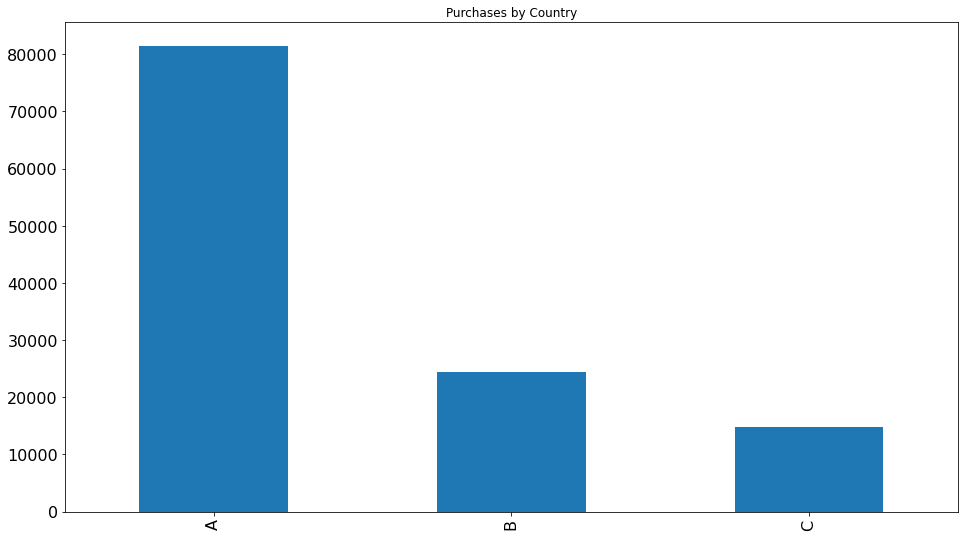

In [24]:
trx['country'].value_counts().plot(kind='bar', figsize=(16,9), fontsize = 16, title = 'Purchases by Country');

Text(0, 0.5, 'Number of Transactions')

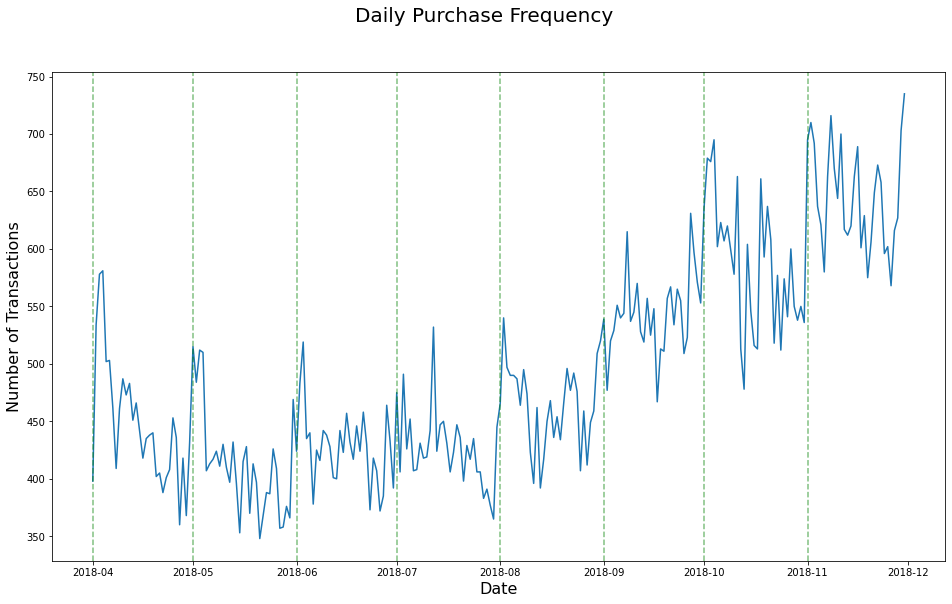

In [25]:
## Limit trx data to end of Nov to make consistent with visitors
trx = trx[trx['date'] <= datetime.strptime('2018-11-30', '%Y-%m-%d').date()]
## Plot Daily transaction frequencies
plt.figure(figsize=(16,9))
plt.plot(trx['date'].value_counts().sort_index())
for month in set(trx['date_time'].dt.month):
    plt.axvline(datetime(2018,month,1), linestyle='--', color='green', alpha=0.5)
plt.suptitle('Daily Purchase Frequency', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of Transactions', fontsize=16)

While there are sharp spikes in the transactions, for the first 5 months, the **trend** holds steady. For the next 4 months there is an increasing trend in the transactions as the year enters the holiday season (Halloween, Thanksgiving).

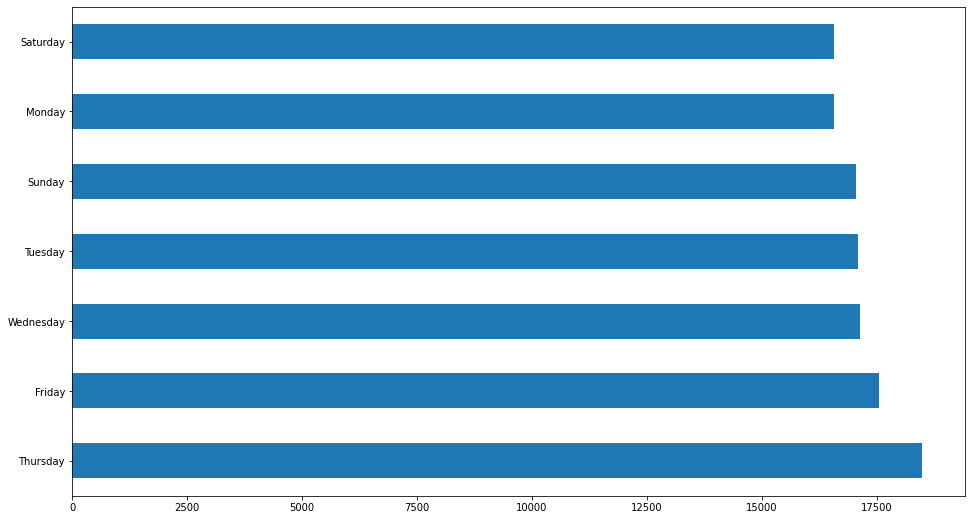

In [26]:
trx['day_of_week'].value_counts().plot(kind='barh', figsize=(16,9));

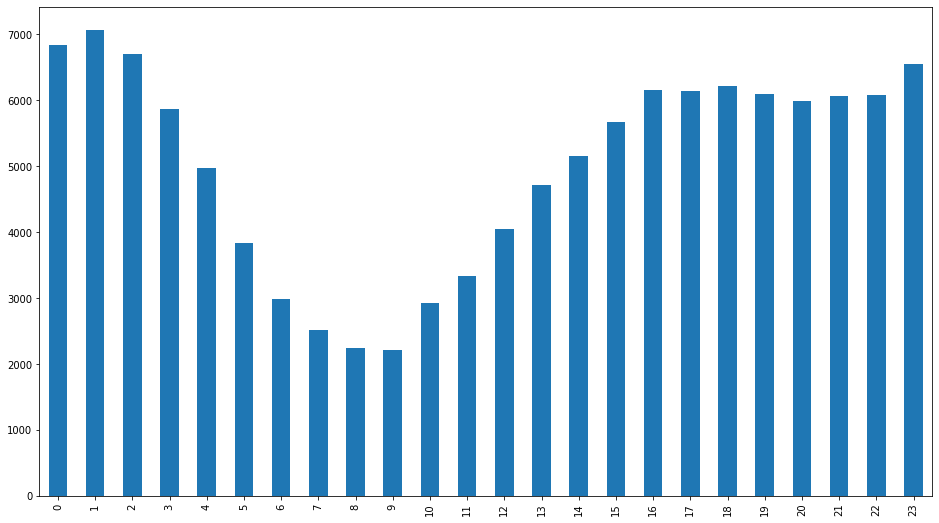

In [27]:
trx['hour_of_day'].value_counts().sort_index().plot(kind='bar', figsize=(16,9));

#### Remove outliers

In [28]:
q25, q75 = np.percentile(trx['total'], 25), np.percentile(trx['total'], 75)
iqr = q75 - q25
print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
# calculate the outlier cutoff
cut_off = iqr * 5
upper = q75 + cut_off
# trx_subset = trx[trx['total']]
print(upper)
print(trx[trx['total'] > upper].shape[0])
trx_new = trx[trx['total'] < upper]

Percentiles: 25th=9.280, 75th=61.860, IQR=52.580
324.76
1934


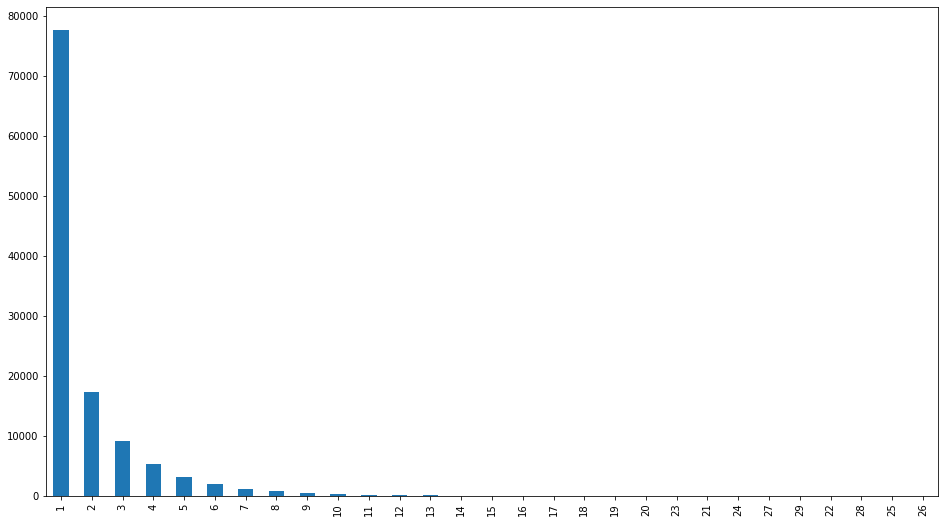

In [29]:
trx_new['items'].value_counts().plot(kind='bar', figsize=(16,9));

<Figure size 1152x648 with 0 Axes>

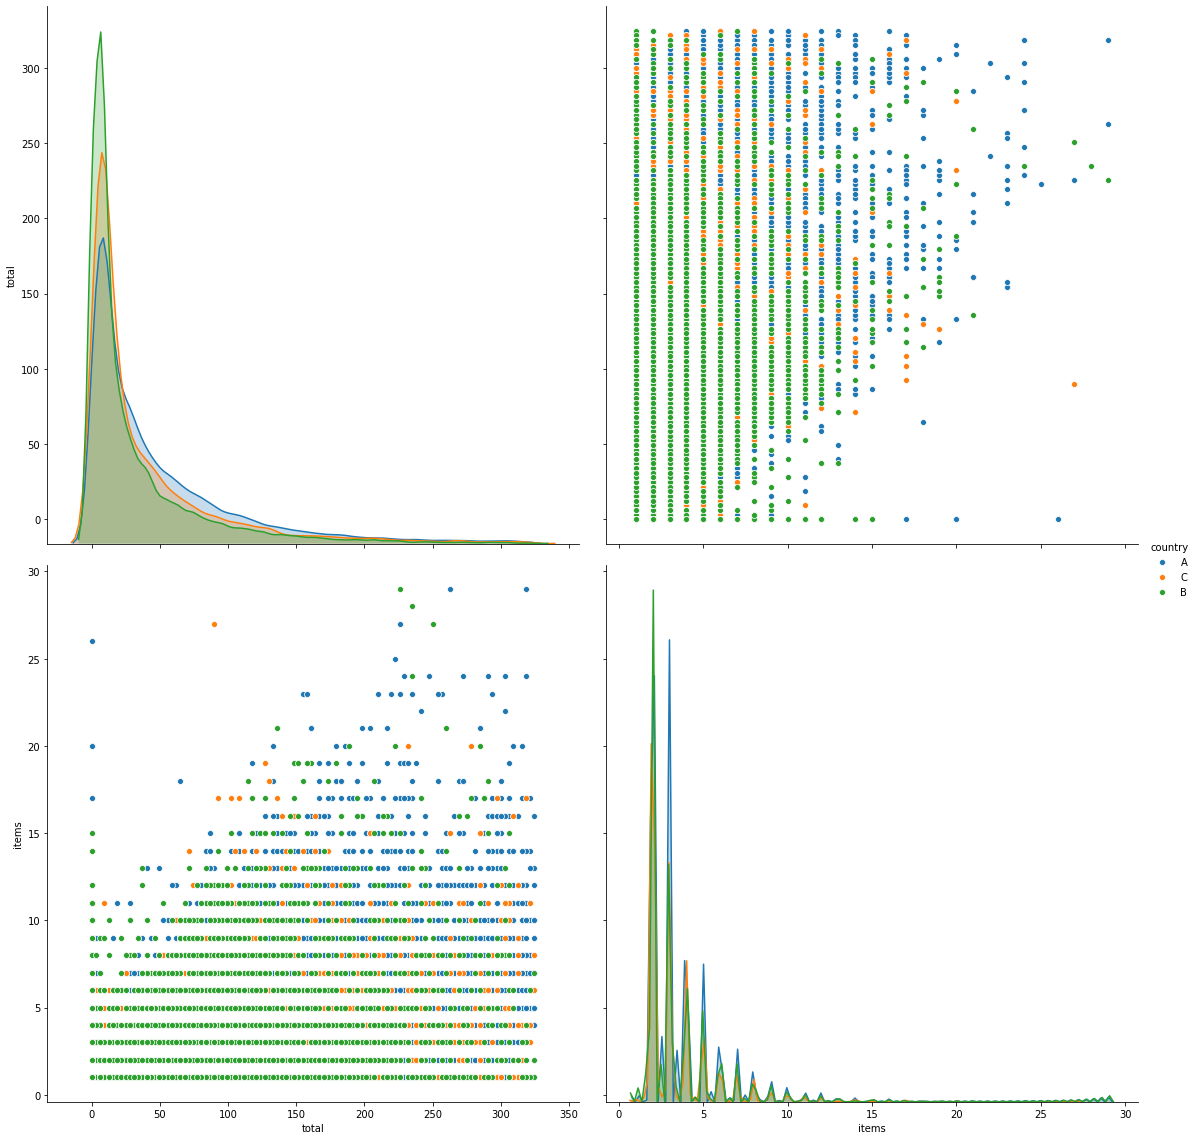

In [30]:
plt.figure(figsize=(16,9))
sns.pairplot(trx_new[['total', 'items', 'country']], diag_kind='kde', height = 8, hue='country');

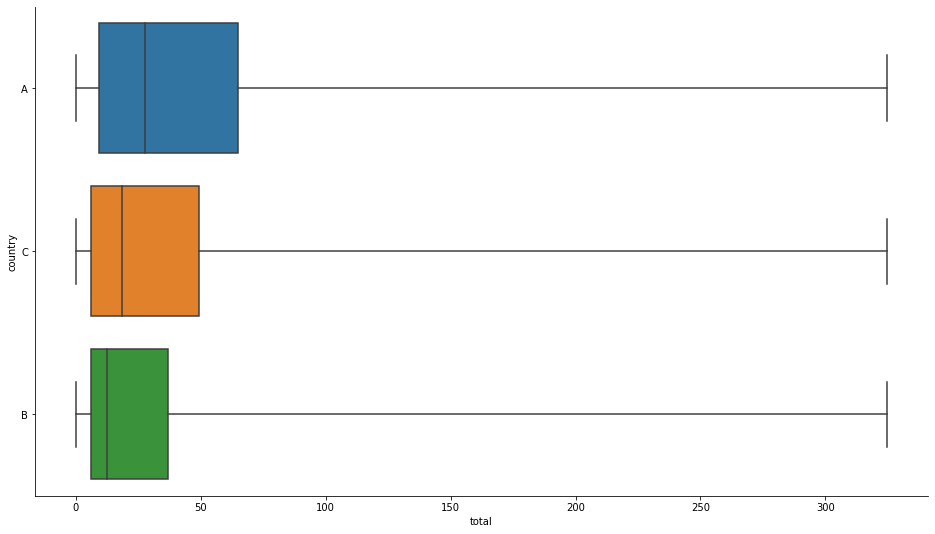

In [31]:
plt.figure(figsize=(16,9))
sns.boxplot(y = "country",
              x = 'total', 
              data = trx_new, whis=np.inf)
sns.despine()

<Figure size 1152x648 with 0 Axes>

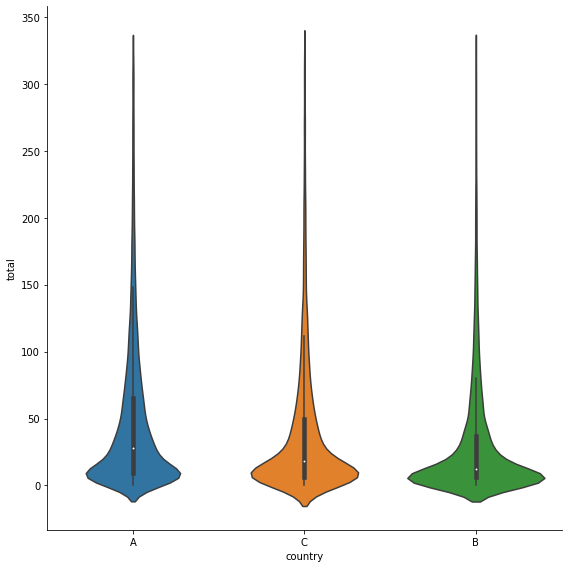

In [32]:
plt.figure(figsize=(16,9))
sns.catplot(x='country', y='total', kind='violin', height = 8, data=trx_new);

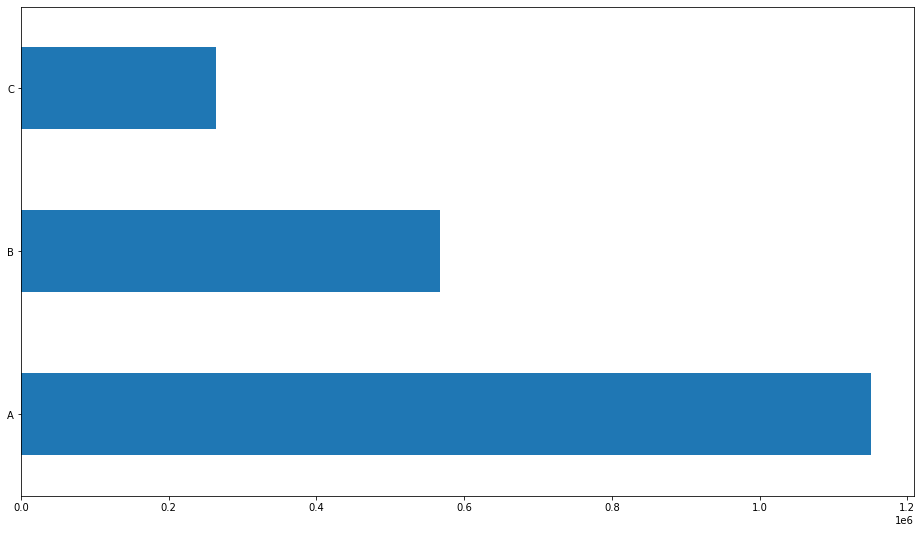

In [33]:
visitors['ip_country'].value_counts().plot(kind='barh', figsize=(16,9))

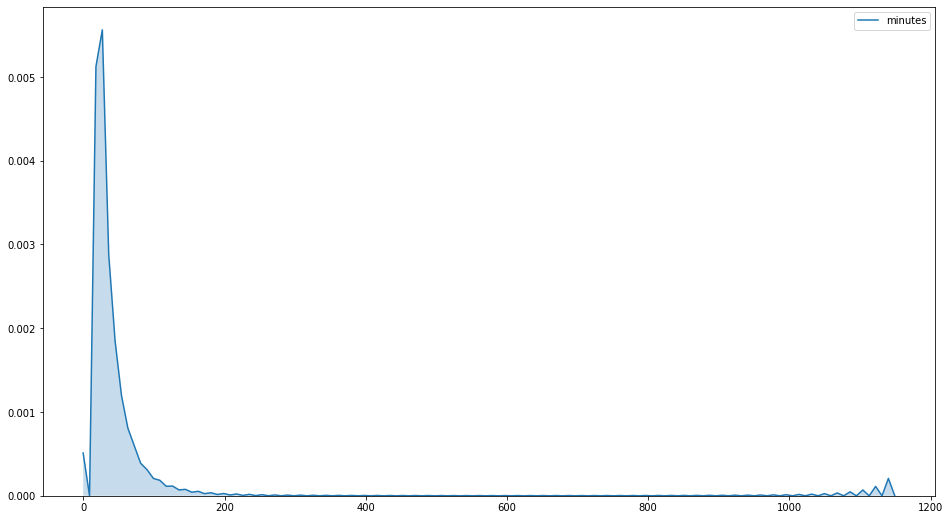

In [34]:
plt.figure(figsize=(16,9))
sns.kdeplot(visitors['minutes'], shade=True);

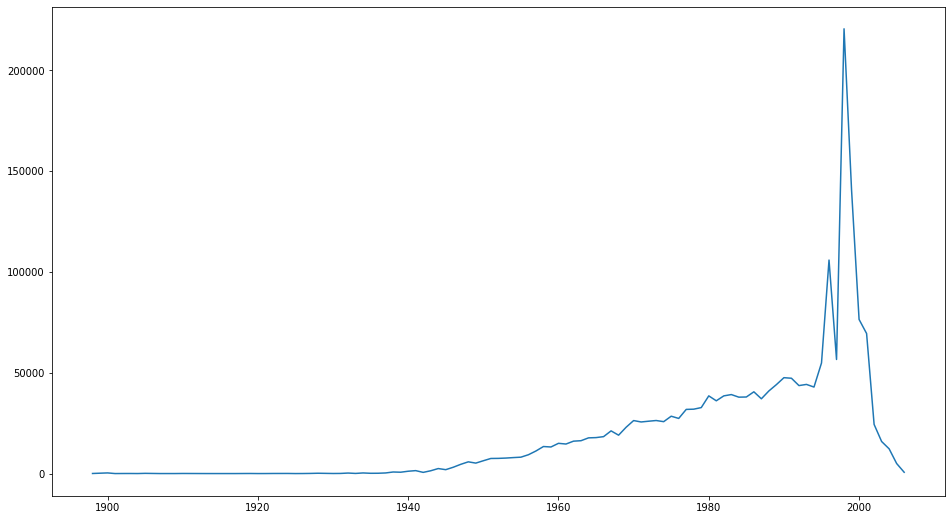

In [35]:
plt.figure(figsize=(16,9))
plt.plot(visitors['year_born'].value_counts().sort_index());

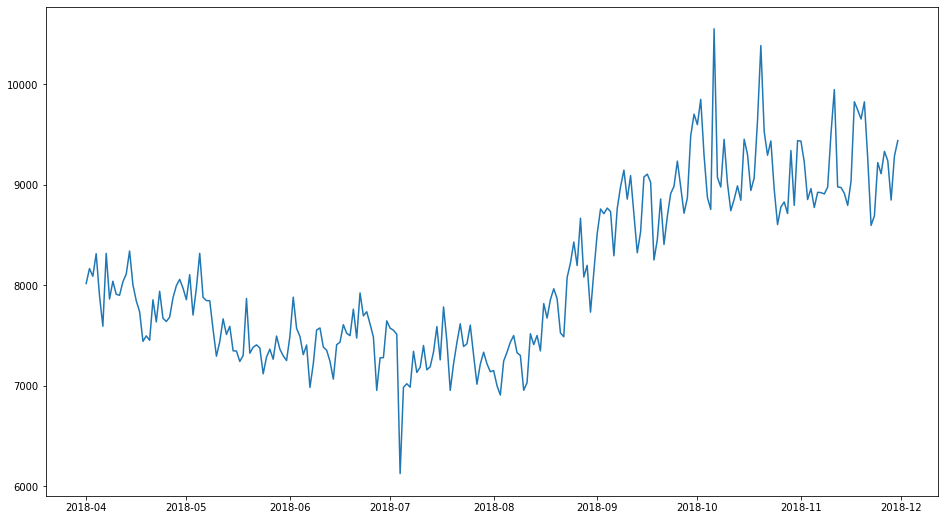

In [36]:
plt.figure(figsize=(16,9))
plt.plot(visitors['date'].value_counts().sort_index());

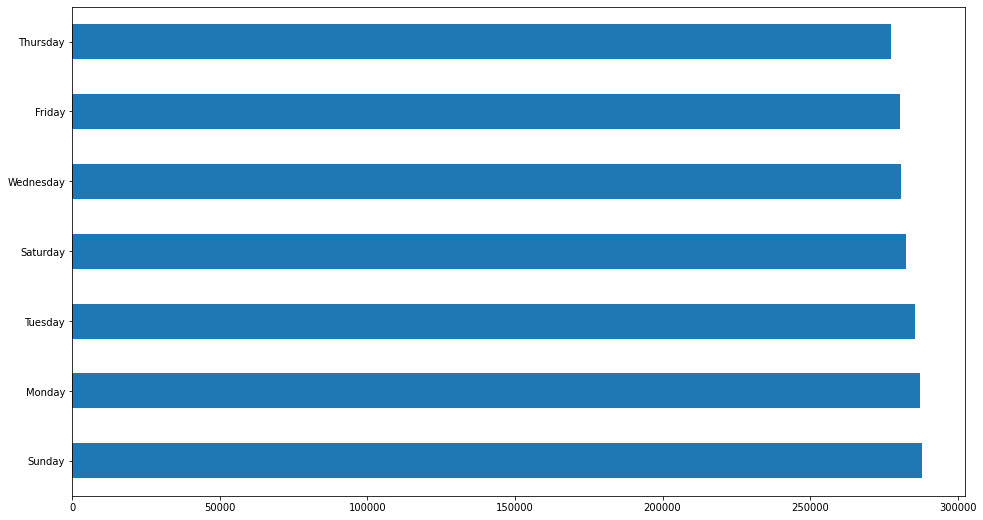

In [37]:
visitors['day_of_week'].value_counts().plot(kind='barh', figsize=(16,9));

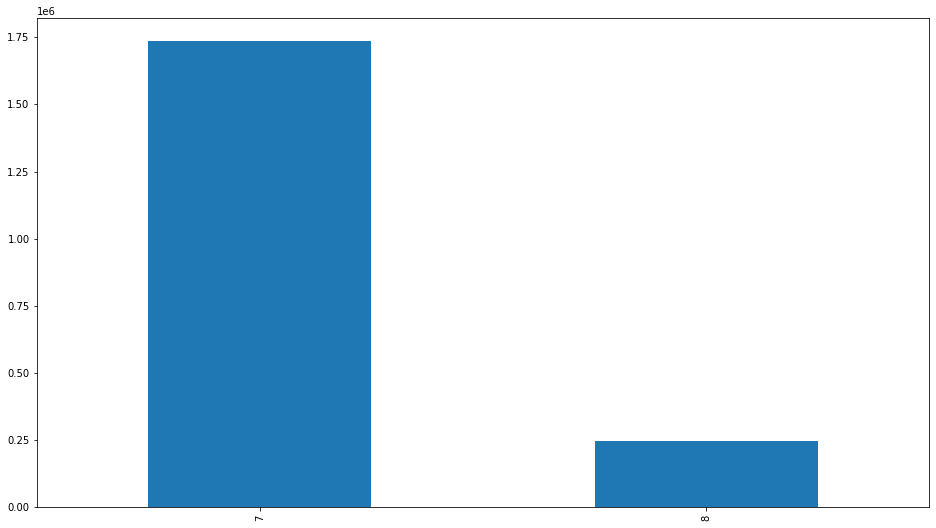

In [38]:
visitors['hour_of_day'].value_counts().sort_index().plot(kind='bar', figsize=(16,9));

The visitors data has a problem, all visits seem to occur only at 7AM UTC and 8AM UTC, which is coincidentally when the online store has the least sales/transactions. This is a problematic bug whith the session tracking feature. This will prevent us from attaching the visit to the transaction accurately since we cannot join on `user_id(trx) + time(trx) == user_id(visitors) + [time(visitors) + minutes]`.
A poor workaround would be to join on date and user_id but the pitfall is we could end up tying a no-purchase session earlier in the day to a purchase transaction from later in the day.

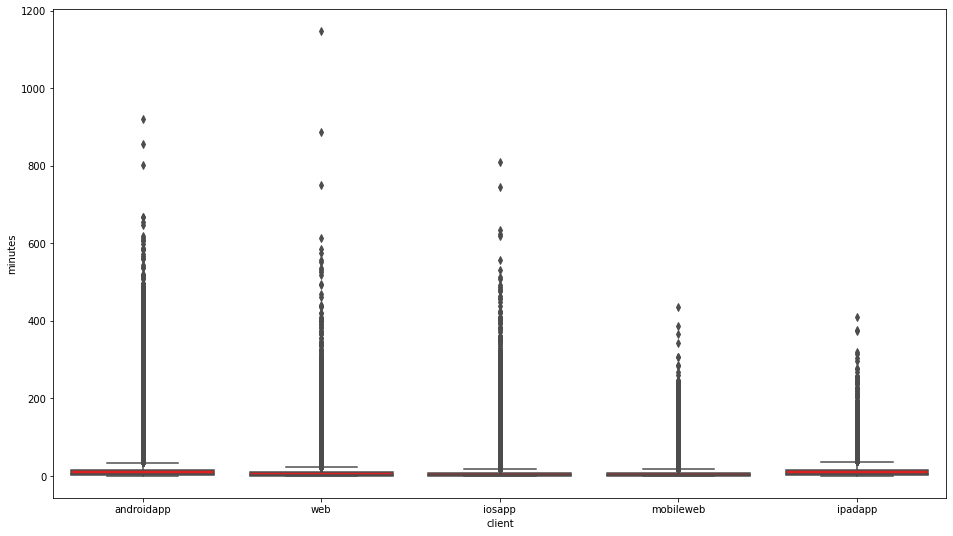

In [39]:
plt.figure(figsize=(16,9))
sns.boxplot(data=visitors, x='client', y='minutes', color='red');

There are a lot of outliers from a session time perspective. It is difficult to imagine spending 200 minutes (3hrs+) or more on an online shopping trip. Unless a session is the time between login and logoff (which many people do not do on apps) as opposed to the time between app start and close (or checkout).

## Building User Profiles

The goal of any online retailer should be to identify the drivers that drive customers behavior. We want customers to keep coming back and keep buying from us, to achieve this we need to understand their tastes, preferences and dislikes. To keep track of these behavioral attributes we need to compile all the data we have into meaningful aggregations such as - 
 *  Date of first visit
 *  Number of visits before first purchase
 *  Are they a repeat customer? (returned for 2nd purchase)
 *  Frequency of visits
 *  Frequency of transactions
 *  Average time spent per visit
 *  Average \$ spend per visit
 *  Frequency/Magnitude of returns
 *  Do they use multiple clients?
 *  Do they use a paid tier service/channel?
 *  Favorite day to shop
 *  Favorite time to shop
 *  and many more...
 
Let's get started by grouping `trx` and `visitors` to one row per df. Then on left joining `visitors` and `trx`, we get to treat all visitors as users and customers to identify potential for growth.

In [40]:
user_trx = trx.groupby('user_id').agg(
    transaction_count=pd.NamedAgg(column='transaction_id', aggfunc='count'),
    mean_spend=pd.NamedAgg(column='total', aggfunc='mean'),
    max_spend=pd.NamedAgg(column='total', aggfunc='max'),
    country=pd.NamedAgg(column='country', aggfunc=lambda x: pd.Series.mode(x)[0]),
    return_count=pd.NamedAgg(column='returned_items', aggfunc='mean'),
    first_purchase=pd.NamedAgg(column='date', aggfunc=min),
    last_purchase=pd.NamedAgg(column='date', aggfunc=max),
    favorite_purchase_day=pd.NamedAgg(column='day_of_week', aggfunc=lambda x: pd.Series.mode(x)[0]),
    favorite_purchase_time=pd.NamedAgg(column='hour_of_day', aggfunc=lambda x: pd.Series.mode(x)[0])
)
user_trx.head(10)

,transaction_count,mean_spend,max_spend,country,return_count,first_purchase,last_purchase,favorite_purchase_day,favorite_purchase_time
user_id,,,,,,,,,
000254d704a2edf44dbb734e1b517561,2,132.9900,185.5700,A,0.0000,2018-08-04,2018-11-03,Saturday,16
0005a756366f0d881a9af560d96a40bd,4,108.2450,315.4600,A,0.0000,2018-09-30,2018-11-27,Tuesday,6
000864081fda5b7b5707db65c98b91ca,1,15.4600,15.4600,A,0.0000,2018-06-05,2018-06-05,Tuesday,6
000fc876b4476bcc36af191951afb9b5,1,71.1300,71.1300,A,0.0000,2018-10-05,2018-10-05,Friday,23
0013c370a3053b484111987677c77083,1,6.1900,6.1900,B,0.0000,2018-11-28,2018-11-28,Wednesday,22
0015688adc301d869829406adc30653b,1,3.0900,3.0900,A,0.0000,2018-07-31,2018-07-31,Tuesday,2
001ce4f4b0b137f555bee4a2bfe30766,2,51.0300,71.1300,B,0.0000,2018-10-12,2018-10-24,Friday,15
001d66e2026cfee72d6df31666f83ff2,32,40.2075,194.8500,A,0.0000,2018-07-22,2018-11-24,Saturday,0
001ef0d945aba3b7d2d0ca5b1fc2aeca,1,12.3700,12.3700,A,0.0000,2018-08-12,2018-08-12,Sunday,1


In [41]:
user_visitors = visitors.groupby('user_id').agg(
    visit_count=pd.NamedAgg(column='session_id', aggfunc='count'),
    mean_time_spend=pd.NamedAgg(column='minutes', aggfunc='mean'),
    max_time_spend=pd.NamedAgg(column='minutes', aggfunc='max'),
    country=pd.NamedAgg(column='ip_country', aggfunc=lambda x: pd.Series.mode(x)[0]),
    channel=pd.NamedAgg(column='channel', aggfunc=lambda x: pd.Series.mode(x)[0]),
    channel_count=pd.NamedAgg(column='channel', aggfunc='count'),
    favorite_client=pd.NamedAgg(column='client', aggfunc=lambda x: pd.Series.mode(x)[0]),
    client_count=pd.NamedAgg(column='client', aggfunc='count'),
    gender=pd.NamedAgg(column='gender', aggfunc=lambda x: pd.Series.mode(x)[0]),
    year_born=pd.NamedAgg(column='year_born', aggfunc=max),
    first_visit=pd.NamedAgg(column='date', aggfunc=min),
    last_visit=pd.NamedAgg(column='date', aggfunc=max),
    favorite_visit_day=pd.NamedAgg(column='day_of_week', aggfunc=lambda x: pd.Series.mode(x)[0]),
    favorite_visit_time=pd.NamedAgg(column='hour_of_day', aggfunc=lambda x: pd.Series.mode(x)[0])  
)
user_visitors.head(10)

,visit_count,mean_time_spend,max_time_spend,country,channel,channel_count,favorite_client,client_count,gender,year_born,first_visit,last_visit,favorite_visit_day,favorite_visit_time
user_id,,,,,,,,,,,,,,
0000f79a8363986ff6a888f20dd80e21,1,1.0000,1,A,organic,1,androidapp,1,F,1998,2018-04-13,2018-04-13,Friday,7
0001e14d50ac8d01abbba7abbfe160ed,2,2.5000,4,A,paid,2,androidapp,2,M,1981,2018-08-22,2018-11-02,Friday,7
000254d704a2edf44dbb734e1b517561,86,14.9651,120,A,organic,86,androidapp,86,F,2000,2018-04-01,2018-11-30,Sunday,7
00025ec0d0e649236580c8ab0b3e0ea1,2,5.5000,8,A,organic,2,androidapp,2,M,1987,2018-05-24,2018-06-03,Sunday,7
00048ba7987c16ee71cedca29ef8d3db,6,3.6667,8,A,organic,6,mobileweb,6,M,2000,2018-04-27,2018-06-07,Friday,7
000555375cd8f904ff646e06991938e1,1,1.0000,1,A,organic,1,web,1,F,1992,2018-04-07,2018-04-07,Saturday,7
0005a756366f0d881a9af560d96a40bd,23,14.7826,85,A,organic,23,androidapp,23,F,1995,2018-09-20,2018-11-30,Friday,7
0006695ef1e5dabaa69f18cec5bff572,1,9.0000,9,A,organic,1,iosapp,1,F,1968,2018-04-19,2018-04-19,Thursday,7
0006a03d838f93d5441f2b2a81b17537,20,22.3000,83,A,organic,20,androidapp,20,M,1972,2018-05-21,2018-11-05,Friday,7


In [42]:
all_users = user_visitors.merge(user_trx, on='user_id', how='left')
all_users.head()

,visit_count,mean_time_spend,max_time_spend,country_x,channel,channel_count,favorite_client,client_count,gender,year_born,...,favorite_visit_time,transaction_count,mean_spend,max_spend,country_y,return_count,first_purchase,last_purchase,favorite_purchase_day,favorite_purchase_time
user_id,,,,,,,,,,,,,,,,,,,,,
0000f79a8363986ff6a888f20dd80e21,1,1.0000,1,A,organic,1,androidapp,1,F,1998,...,7,nan,nan,nan,NaN,nan,NaN,NaN,NaN,nan
0001e14d50ac8d01abbba7abbfe160ed,2,2.5000,4,A,paid,2,androidapp,2,M,1981,...,7,nan,nan,nan,NaN,nan,NaN,NaN,NaN,nan
000254d704a2edf44dbb734e1b517561,86,14.9651,120,A,organic,86,androidapp,86,F,2000,...,7,2.0000,132.9900,185.5700,A,0.0000,2018-08-04,2018-11-03,Saturday,16.0000
00025ec0d0e649236580c8ab0b3e0ea1,2,5.5000,8,A,organic,2,androidapp,2,M,1987,...,7,nan,nan,nan,NaN,nan,NaN,NaN,NaN,nan
00048ba7987c16ee71cedca29ef8d3db,6,3.6667,8,A,organic,6,mobileweb,6,M,2000,...,7,nan,nan,nan,NaN,nan,NaN,NaN,NaN,nan


In [43]:
all_users.drop(['country_y'], axis = 1, inplace=True)
all_users.rename({'country_x':'country'}, axis=1, inplace=True)
all_users['transaction_count'].fillna(0, inplace=True)
all_users['mean_spend'].fillna(0, inplace=True)
all_users['max_spend'].fillna(0, inplace=True)
all_users['return_count'].fillna(0, inplace=True)
all_users.head()

,visit_count,mean_time_spend,max_time_spend,country,channel,channel_count,favorite_client,client_count,gender,year_born,...,favorite_visit_day,favorite_visit_time,transaction_count,mean_spend,max_spend,return_count,first_purchase,last_purchase,favorite_purchase_day,favorite_purchase_time
user_id,,,,,,,,,,,,,,,,,,,,,
0000f79a8363986ff6a888f20dd80e21,1,1.0000,1,A,organic,1,androidapp,1,F,1998,...,Friday,7,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,nan
0001e14d50ac8d01abbba7abbfe160ed,2,2.5000,4,A,paid,2,androidapp,2,M,1981,...,Friday,7,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,nan
000254d704a2edf44dbb734e1b517561,86,14.9651,120,A,organic,86,androidapp,86,F,2000,...,Sunday,7,2.0000,132.9900,185.5700,0.0000,2018-08-04,2018-11-03,Saturday,16.0000
00025ec0d0e649236580c8ab0b3e0ea1,2,5.5000,8,A,organic,2,androidapp,2,M,1987,...,Sunday,7,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,nan
00048ba7987c16ee71cedca29ef8d3db,6,3.6667,8,A,organic,6,mobileweb,6,M,2000,...,Friday,7,0.0000,0.0000,0.0000,0.0000,NaN,NaN,NaN,nan


In [44]:
all_users['return_buyer'] = 0
all_users['multiple_clients'] = 0
all_users['multiple_channels'] = 0
all_users.loc[all_users['transaction_count'] >= 2, 'return_buyer'] = 1
all_users.loc[all_users['client_count'] >= 2, 'multiple_clients'] = 1
all_users.loc[all_users['channel_count'] >= 2, 'multiple_channels'] = 1
all_users.head()

,visit_count,mean_time_spend,max_time_spend,country,channel,channel_count,favorite_client,client_count,gender,year_born,...,mean_spend,max_spend,return_count,first_purchase,last_purchase,favorite_purchase_day,favorite_purchase_time,return_buyer,multiple_clients,multiple_channels
user_id,,,,,,,,,,,,,,,,,,,,,
0000f79a8363986ff6a888f20dd80e21,1,1.0000,1,A,organic,1,androidapp,1,F,1998,...,0.0000,0.0000,0.0000,NaN,NaN,NaN,nan,0,0,0
0001e14d50ac8d01abbba7abbfe160ed,2,2.5000,4,A,paid,2,androidapp,2,M,1981,...,0.0000,0.0000,0.0000,NaN,NaN,NaN,nan,0,1,1
000254d704a2edf44dbb734e1b517561,86,14.9651,120,A,organic,86,androidapp,86,F,2000,...,132.9900,185.5700,0.0000,2018-08-04,2018-11-03,Saturday,16.0000,1,1,1
00025ec0d0e649236580c8ab0b3e0ea1,2,5.5000,8,A,organic,2,androidapp,2,M,1987,...,0.0000,0.0000,0.0000,NaN,NaN,NaN,nan,0,1,1
00048ba7987c16ee71cedca29ef8d3db,6,3.6667,8,A,organic,6,mobileweb,6,M,2000,...,0.0000,0.0000,0.0000,NaN,NaN,NaN,nan,0,1,1


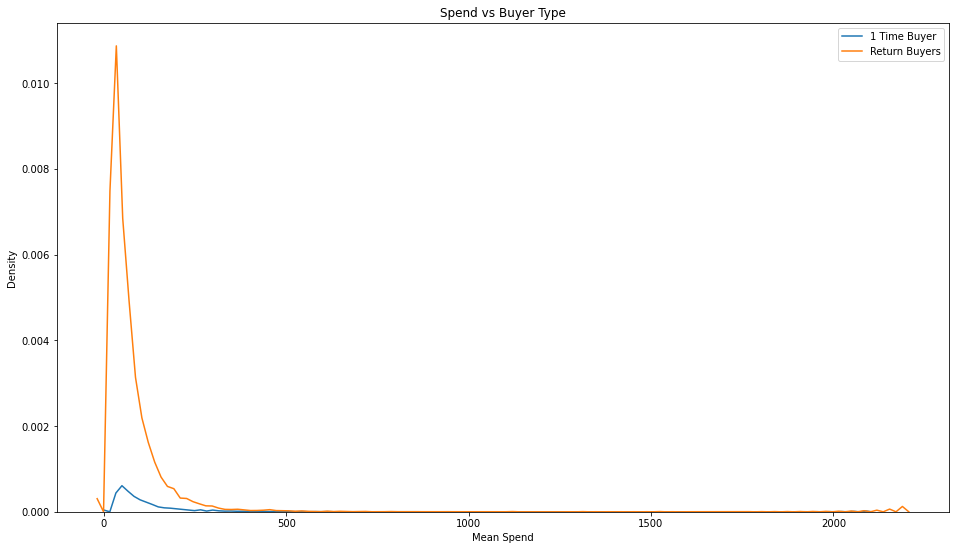

In [49]:
plt.figure(figsize=(16,9))
sns.distplot(all_users[all_users['return_buyer'] == 0]['mean_spend'], hist=False, label = '1 Time Buyer')
sns.distplot(all_users[all_users['return_buyer'] == 1]['mean_spend'], hist=False, label = 'Return Buyers')
plt.title('Spend vs Buyer Type')
plt.xlabel('Mean Spend')
plt.ylabel('Density')

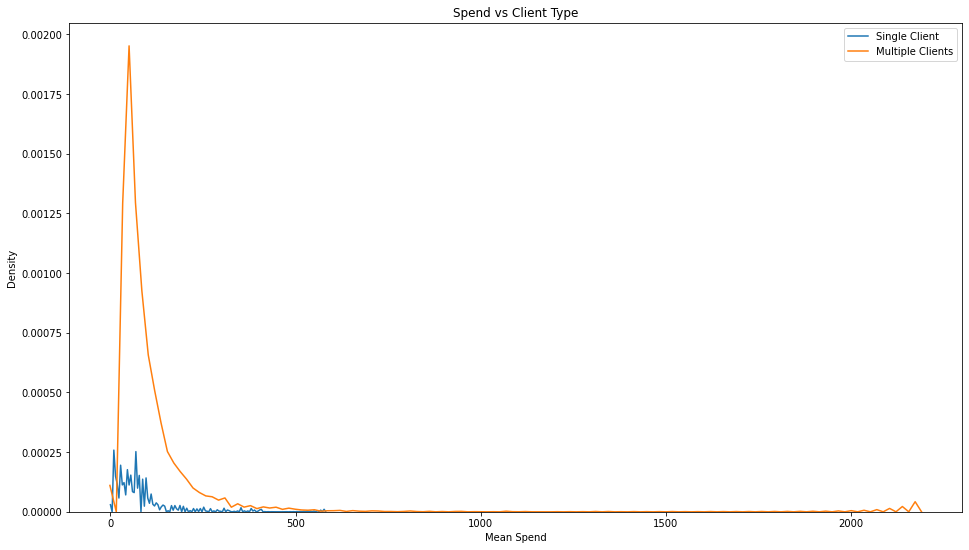

In [51]:
plt.figure(figsize=(16,9))
sns.distplot(all_users[all_users['multiple_clients'] == 0]['mean_spend'], hist=False, label = 'Single Client')
sns.distplot(all_users[all_users['multiple_clients'] == 1]['mean_spend'], hist=False, label = 'Multiple Clients')
plt.title('Spend vs Client Type')
plt.xlabel('Mean Spend')
plt.ylabel('Density');

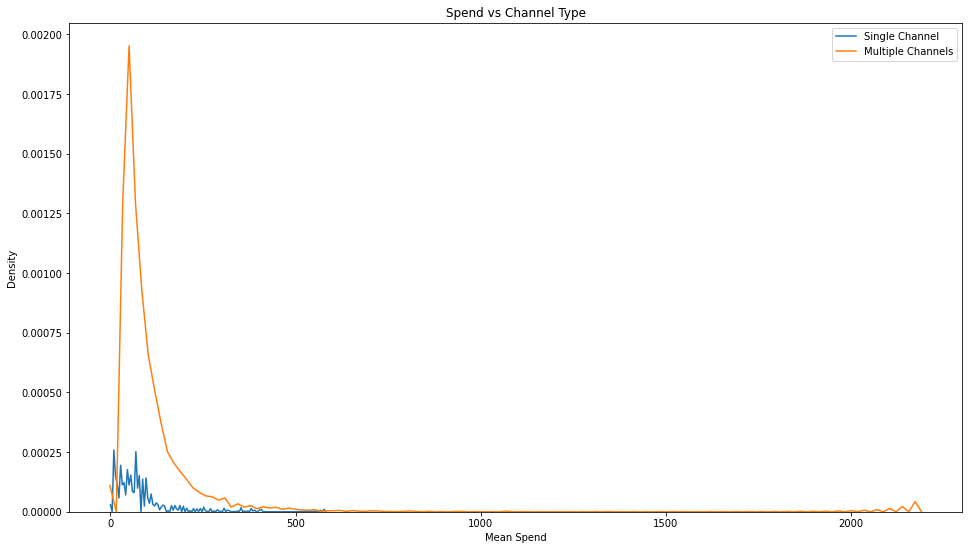

In [52]:
plt.figure(figsize=(16,9))
sns.distplot(all_users[all_users['multiple_channels'] == 0]['mean_spend'], hist=False, label = 'Single Channel')
sns.distplot(all_users[all_users['multiple_channels'] == 1]['mean_spend'], hist=False, label = 'Multiple Channels')
plt.title('Spend vs Channel Type')
plt.xlabel('Mean Spend')
plt.ylabel('Density');

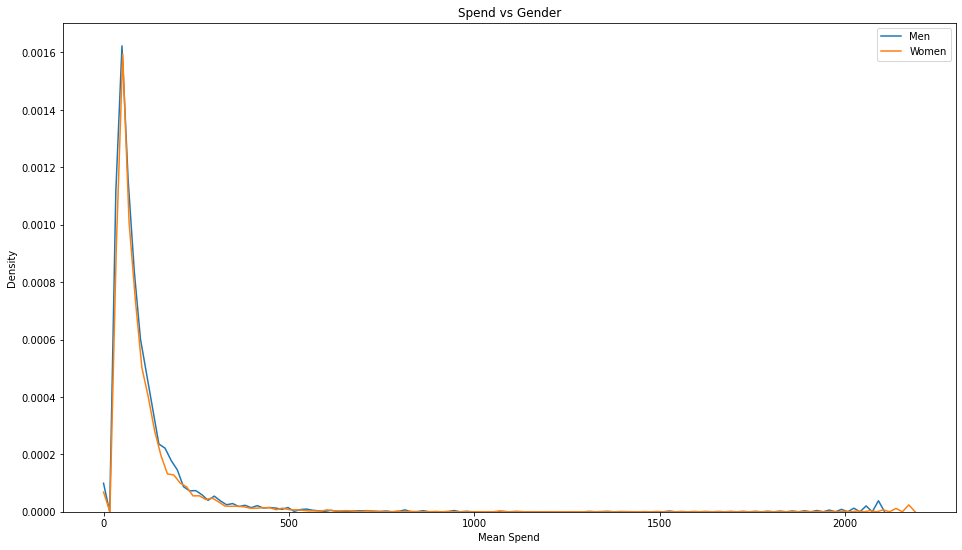

In [58]:
plt.figure(figsize=(16,9))
sns.distplot(all_users[all_users['gender'] == 'M']['mean_spend'], hist=False, label = 'Men')
sns.distplot(all_users[all_users['gender'] == 'F']['mean_spend'], hist=False, label = 'Women')
plt.title('Spend vs Gender')
plt.xlabel('Mean Spend')
plt.ylabel('Density');

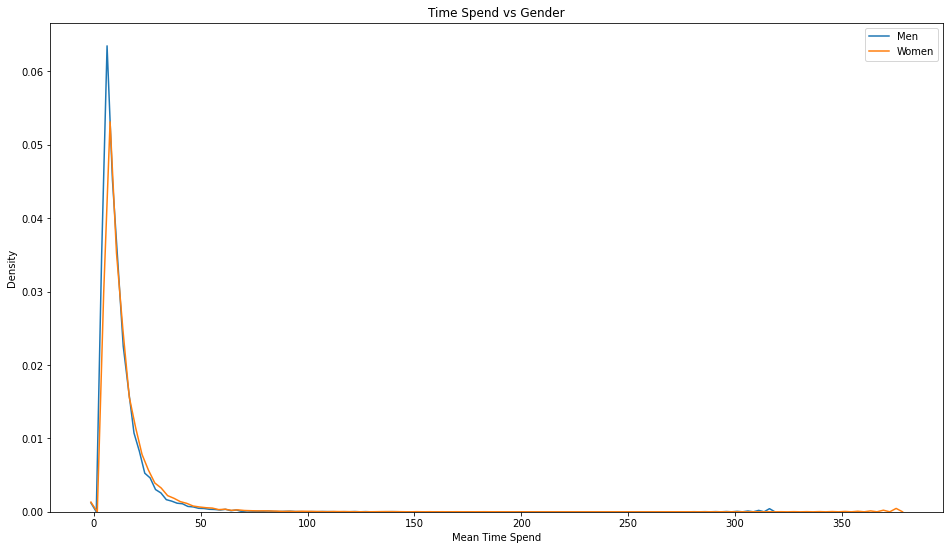

In [59]:
plt.figure(figsize=(16,9))
sns.distplot(all_users[all_users['gender'] == 'M']['mean_time_spend'], hist=False, label = 'Men')
sns.distplot(all_users[all_users['gender'] == 'F']['mean_time_spend'], hist=False, label = 'Women')
plt.title('Time Spend vs Gender')
plt.xlabel('Mean Time Spend')
plt.ylabel('Density');

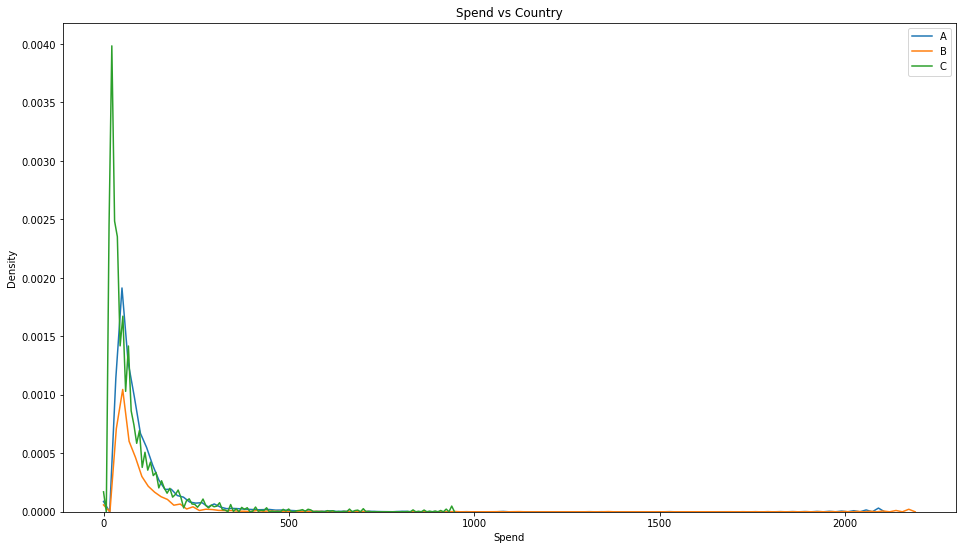

In [60]:
plt.figure(figsize=(16,9))
sns.distplot(all_users[all_users['country'] == 'A']['mean_spend'], hist=False, label = 'A')
sns.distplot(all_users[all_users['country'] == 'B']['mean_spend'], hist=False, label = 'B')
sns.distplot(all_users[all_users['country'] == 'C']['mean_spend'], hist=False, label = 'C')
plt.title('Spend vs Country')
plt.xlabel('Spend')
plt.ylabel('Density');

C:\anaconda\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\anaconda\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


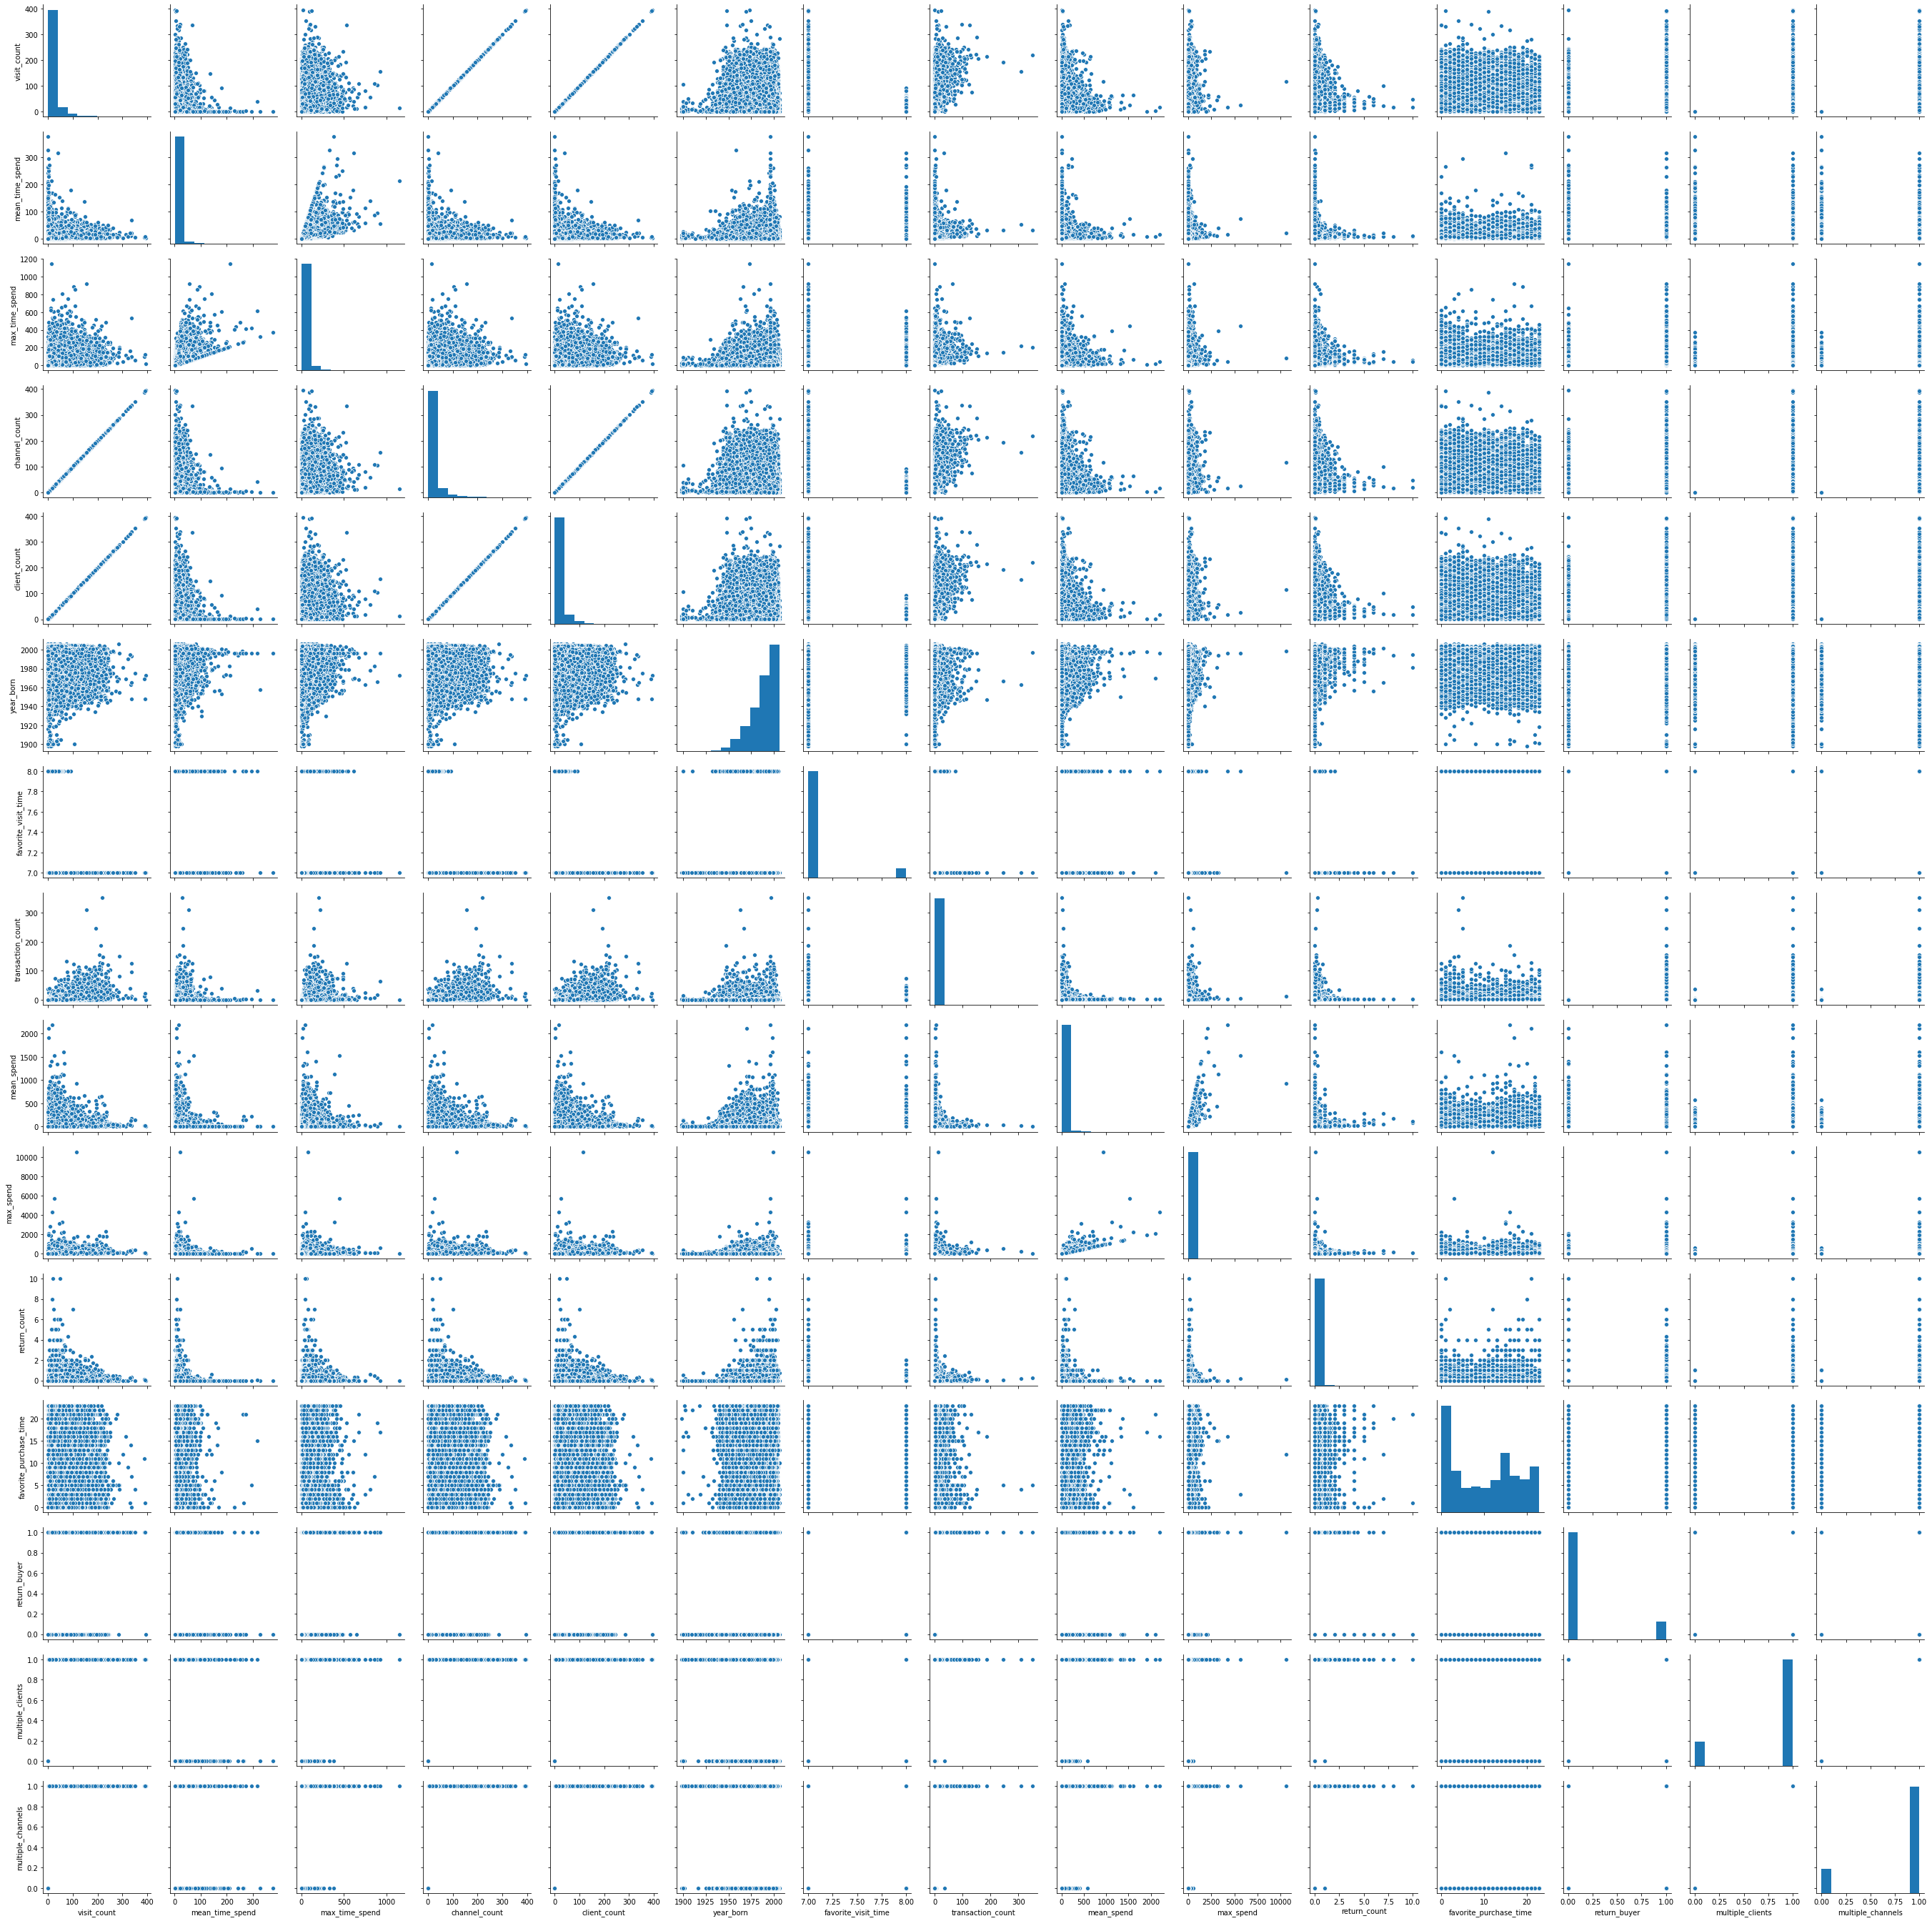

In [61]:
# all_users['country_x'].value_counts()
g = sns.pairplot(all_users)